# 1. Đọc dataframe

In [106]:
import os
import json
import pandas as pd


folder_paths = {
    'C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dataset/Fake/Article_Contents': 'Fake',
    'C:/Users/VivoBook/Documents/detect fake news/VFND-vietnamese-fake-news-datasets/Dataset/Real/Article_Contents': 'Real'
    }

dfs = [] 

for folder_path, label in folder_paths.items():
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]  # Lọc file JSON

    for file in json_files:
        file_path = os.path.join(folder_path, file)  # Đường dẫn file JSON
        
        try:
            # Đọc file JSON
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            # Nếu JSON là dictionary thay vì danh sách, chuyển thành danh sách
            if isinstance(data, dict):
                data = [data]

            # Chuyển đổi thành DataFrame
            df = pd.DataFrame(data)

            # Kiểm tra nếu DataFrame không có dòng nào
            if df.shape[0] == 0:
                print(f"File {file} không có dữ liệu.")
                continue

            # Trích xuất ID từ tên file (Fake_68, Real_15, ...)
            file_parts = file.split("_")  # Tách chuỗi theo dấu "_"
            file_id = "_".join(file_parts[-2:]).replace(".json", "")  # Lấy phần cuối của tên file
            
            # Thống nhất maintext và text thành maintext
            if "text" in df.columns:
                df.rename(columns={"text": "maintext"}, inplace=True)
            if "maintext" not in df.columns:  
                df["maintext"] = ""  # Nếu không có cả 2, đặt giá trị rỗng

            # Kiểm tra và xử lý cột "authors"
            if "authors" in df.columns:
                df["authors"] = df["authors"].apply(lambda x: ", ".join(x) if isinstance(x, list) and len(x) > 0 else "")
            # else:
            #     df["authors"] = ""  # Nếu không có cột "authors", đặt giá trị rỗng

            # Thêm cột ID và target (Fake/Real)
            df['id'] = file_id  
            df['target'] = label  

            dfs.append(df)

        except Exception as e:
            print(f"Lỗi khi đọc file {file}: {e}")

# Gộp tất cả DataFrame lại (giữ tất cả cột)
df = pd.concat(dfs, ignore_index=True, join='outer')

# Điền giá trị trống bằng chuỗi rỗng
df = df.fillna('')

# Reset index
df.reset_index(drop=True, inplace=True)


In [107]:
df = df[['id', 'authors', 'source_domain', 'language', 'title', 'description', 'maintext', 'target']]
df.reset_index(drop=True, inplace=True)
df.head()

,id,authors,source_domain,language,title,description,maintext,target
0,Fake_0,,2sao.vn,vi,Con gái chính là người tình kiếp trước của cha...,Tình phụ tử: Cách yêu thương của cha giành cho...,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake
1,Fake_1,Văn Trình,binhluan.biz,en,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,,"Theo Sankei Sports, sáng nay Thủ tướng Nhật Bả...",Fake
2,Fake_10,,suckhoe.vnexpress.net,vi,Bức vẽ giúp bạn đánh giá mức độ stress của bản...,Bức vẽ gồm một hình cầu dường như đang trượt m...,"Nhìn bức tranh, bạn có thể thấy vòng tròn đang...",Fake
3,Fake_100,,www.vietgiaitri.com,vi,YÊU RÂU XANH (P51): Câu chuyện động trời sau t...,"Đúng lúc đó, một người hàng xóm nhà bà H sang ...","Sau khi vụ án xảy ra, tất cả mọi người đều khô...",Fake
4,Fake_101,,mangxahoi.net,vi,"NÓNG : xử phạt 10 đối tượng ""bom"" hàng "" Lợi d...",,"ĐANG RẤT QUÁ TẢI, MONG MỌI NGƯỜI Ý THỨC! NGƯỜI...",Fake


In [108]:
df.shape

(260, 8)

# 2. Tiền xử lí tập dữ liệu

In [109]:
df.describe()

,id,authors,source_domain,language,title,description,maintext,target
count,260,260,260,260,260,260,260,260
unique,260,32,54,3,258,226,259,2
top,Fake_0,,vnexpress.net,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake
freq,1,209,74,233,2,34,2,132


Thuộc tính Language có quá ít giá trị (vi, en, rỗng) so với các thuộc tính khác, vì vậy language sẽ không đóng vai trò nhiều trong decision tree.

In [110]:
# Kiểm tra duplicates
df[df.duplicated(subset=df.columns.difference(['id']), keep=False)]


,id,authors,source_domain,language,title,description,maintext,target
69,Fake_42,,tinvn.info,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake
105,Fake_75,,tinvn.info,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake


In [111]:
df.drop(index=105, inplace=True)  # Xóa dòng có index = 105
df.reset_index(drop=True, inplace=True)  # Reset index, bỏ index cũ


In [112]:
df['target'].value_counts()  # Tỉ lệ giữa Fake và Real xấp xỉ nhau nên dataset này đã cân bằng (balance)

target
Fake    131
Real    128
Name: count, dtype: int64

# 3. Tìm rule-based system

In [113]:
# df = df[['authors', 'source_domain', 'title', 'target']]

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [133]:
# 2. Chuyển đổi văn bản thành số (sử dụng TF-IDF)
vectorizer = TfidfVectorizer(max_features=30)  # Giới hạn số từ đặc trưng
text_features = vectorizer.fit_transform(df["title"] + " " + df["description"] + " " + df["maintext"]).toarray()
# vectorizer = TfidfVectorizer(max_features=20)
# text_features = vectorizer.fit_transform(df["title"] ).toarray()
text_features.shape


(259, 30)

In [125]:
vectorizer.get_feature_names_out()

array(['cho', 'con', 'các', 'có', 'của', 'khi', 'không', 'là', 'một',
       'người', 'những', 'này', 'ra', 'trong', 'tôi', 'và', 'với', 'đã',
       'được', 'để'], dtype=object)

In [134]:
# 3. Chuyển đổi 'source_domain' và 'authors' thành số (dùng LabelEncoder)
encoder = LabelEncoder()
df["source_domain"] = encoder.fit_transform(df["source_domain"])
df["authors"] = encoder.fit_transform(df["authors"])


In [135]:
# 4. Kết hợp tất cả đặc trưng vào ma trận X
X = np.hstack((df[["source_domain", "authors"]].values, text_features))
# X = text_features
y = df["target"]
X.shape

(259, 32)

In [136]:
# 5. Huấn luyện Decision Tree
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X, y)

# 6. Xuất quy luật từ cây quyết định
tree_rules = export_text(clf, feature_names=["source_domain", "authors"] + list(vectorizer.get_feature_names_out()))
# tree_rules = export_text(clf)
print(tree_rules)

|--- source_domain <= 42.50
|   |--- source_domain <= 35.50
|   |   |--- source_domain <= 9.50
|   |   |   |--- class: Fake
|   |   |--- source_domain >  9.50
|   |   |   |--- class: Real
|   |--- source_domain >  35.50
|   |   |--- class: Fake
|--- source_domain >  42.50
|   |--- source_domain <= 49.50
|   |   |--- source_domain <= 46.50
|   |   |   |--- class: Real
|   |   |--- source_domain >  46.50
|   |   |   |--- class: Real
|   |--- source_domain >  49.50
|   |   |--- class: Fake



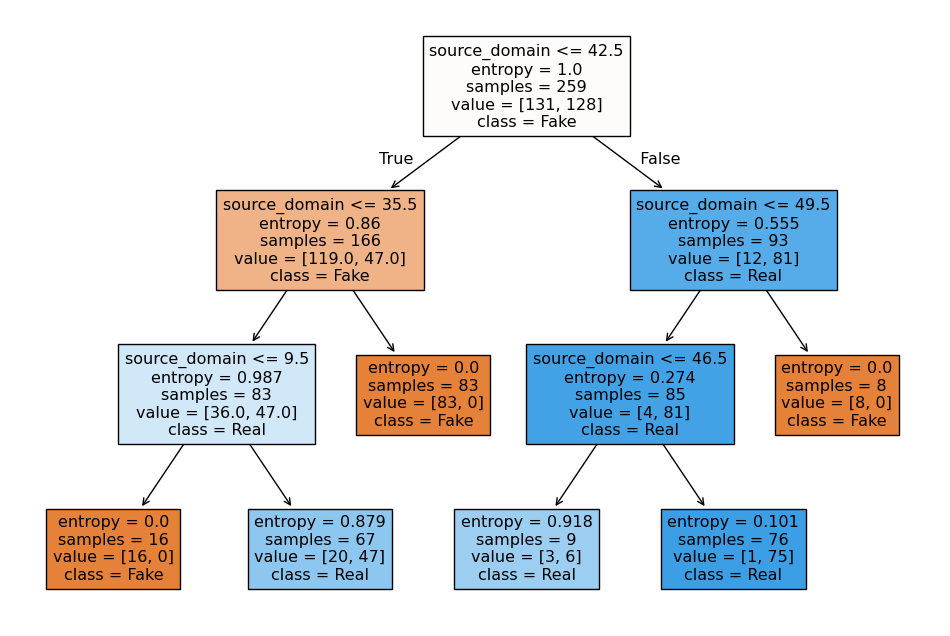

In [137]:
# clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
# clf.fit(X, y)

# Vẽ cây quyết định
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=["source_domain", "authors"] + list(vectorizer.get_feature_names_out()),
          class_names=["Fake", "Real"], filled=True)
plt.show()

In [138]:
# df['source_domain']

In [139]:
# 3. Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Huấn luyện mô hình Decision Tree
# clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# 5. Dự đoán & tính Accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy của Decision Tree: {accuracy:.2%}")

Accuracy của Decision Tree: 88.46%


# 4. Rule-based system

In [140]:
def rule_based_classification(row):
    """
    Hệ thống Rule-Based để phân loại Fake/Real dựa vào cây quyết định.
    """
    source_domain = row["source_domain"]
    word_con = row["word_con"]  # Tần suất từ "con"
    word_co = row["word_co"]    # Tần suất từ "có"

    # Rule 1: Dựa vào source_domain
    if source_domain <= 9.50:
        return "Fake"
    elif 9.50 < source_domain <= 35.50:
        return "Real"
    elif 35.50 < source_domain <= 42.50:
        return "Fake"
    
    # Rule 2: Nếu source_domain > 42.50, xét tiếp
    if source_domain <= 47.50:
        if word_con <= 0.84:
            return "Real"
        else:
            return "Fake"
    else:  # source_domain > 47.50
        if word_co <= 0.31:
            return "Fake"
        else:
            return "Real"